### 1: Initial Setup and Imports

This cell imports all necessary libraries for the project.
- `tensorflow` and `tensorflow_datasets` for loading and initially processing the EuroSAT dataset.
- `torch`, `torch.nn`, `torch.optim`, `torch.nn.functional` for building and training the ResNet model in PyTorch.
- `torchvision.transforms` for PyTorch-specific image augmentations and normalization.
- `torch.utils.data.DataLoader` and `TensorDataset` for creating PyTorch data loaders.
- `numpy` for numerical operations, especially during data conversion.
- `matplotlib.pyplot` for plotting.
- `time`, `os`, `copy` for utility functions.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

###  2: Configuration and EuroSAT Data Preparation

This cell sets up basic configurations and prepares the EuroSAT dataset.
1.  **Configuration:** Defines device (CPU/GPU), image size, batch size, and number of classes.
2.  **Data Loading (TFDS):** Loads the EuroSAT RGB dataset. Since EuroSAT only has a 'train' split, this split is manually divided into training, validation, and test sets (70%/15%/15%).
3.  **TF Preprocessing:** A `preprocess_image` function resizes images to the target `IMAGE_SIZE` and converts them to float32. This is mapped to the TensorFlow datasets.
4.  **PyTorch Transforms:** Defines PyTorch `transforms.Compose` objects for training (with augmentation like `RandomCrop`, `RandomHorizontalFlip`) and for validation/testing (only normalization). ImageNet normalization statistics are used as a starting point.
5.  **Conversion to PyTorch Loaders:** A helper function `tf_to_pytorch_loader` converts the batched TensorFlow `tf.data.Dataset` objects (after TF preprocessing) into PyTorch `TensorDataset` and then `DataLoader` objects. This function also handles the application of PyTorch-specific transforms.
6.  

In [ ]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 32
BATCH_SIZE = 128
NUM_CLASSES = 10

print(f"Using device: {DEVICE}")
print("==> Preparing EuroSAT data...")


dataset, ds_info = tfds.load(
    'eurosat/rgb',
    split='train',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


DATASET_SIZE = ds_info.splits['train'].num_examples
TRAIN_SPLIT_PERCENT = 0.7
VAL_SPLIT_PERCENT = 0.15

train_size = int(TRAIN_SPLIT_PERCENT * DATASET_SIZE)
val_size = int(VAL_SPLIT_PERCENT * DATASET_SIZE)
test_size = DATASET_SIZE - train_size - val_size

print(f"Total dataset size: {DATASET_SIZE}")
print(f"Training samples: {train_size}, Validation samples: {val_size}, Test samples: {test_size}")


dataset = dataset.shuffle(DATASET_SIZE, seed=42)

ds_train = dataset.take(train_size)
ds_val_test = dataset.skip(train_size)
ds_val = ds_val_test.take(val_size)
ds_test = ds_val_test.skip(val_size)


def preprocess_tf_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Scale to [0,1]
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    return image, label

ds_train = ds_train.map(preprocess_tf_image, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess_tf_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_tf_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

class_names = ds_info.features['label'].names
print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names: {class_names}")


normalize_transform = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

transform_train_pt = transforms.Compose([
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    transforms.RandomHorizontalFlip(),
    normalize_transform
])

transform_test_pt = transforms.Compose([
    normalize_transform
])

def tf_to_pytorch_loader(tf_dataset, batch_size_pt, pytorch_transform=None, shuffle_pt=False, num_workers_pt=2):
    images_list = []
    labels_list = []
    for images_batch, labels_batch in tf_dataset:

        images_torch_batch = torch.tensor(images_batch.numpy()).permute(0, 3, 1, 2)
        labels_torch_batch = torch.tensor(labels_batch.numpy()).long()

        if pytorch_transform:

            transformed_images = torch.stack([pytorch_transform(img) for img in images_torch_batch])
            images_list.append(transformed_images)
        else:
            images_list.append(images_torch_batch)
        labels_list.append(labels_torch_batch)

    if not images_list:
        all_images = torch.empty(0, 3, IMAGE_SIZE, IMAGE_SIZE)
        all_labels = torch.empty(0, dtype=torch.long)
    else:
        all_images = torch.cat(images_list, dim=0)
        all_labels = torch.cat(labels_list, dim=0)

    dataset_pt = TensorDataset(all_images, all_labels)

    dataloader_pt = DataLoader(dataset_pt, batch_size=batch_size_pt, shuffle=shuffle_pt, num_workers=num_workers_pt, drop_last= (True if shuffle_pt else False))
    return dataloader_pt

trainloader = tf_to_pytorch_loader(ds_train, BATCH_SIZE, pytorch_transform=transform_train_pt, shuffle_pt=True)
valloader = tf_to_pytorch_loader(ds_val, BATCH_SIZE, pytorch_transform=transform_test_pt, shuffle_pt=False)
testloader = tf_to_pytorch_loader(ds_test, BATCH_SIZE, pytorch_transform=transform_test_pt, shuffle_pt=False)

print("PyTorch DataLoaders created.")

Using device: cuda
==> Preparing EuroSAT data...
Total dataset size: 27000
Training samples: 18900, Validation samples: 4050, Test samples: 4050
Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
PyTorch DataLoaders created.


###  3: Visualizing Dataset Samples

To understand the data we're working with, this cell displays a few sample images from the training set along with their corresponding labels. Images are denormalized for proper visualization.

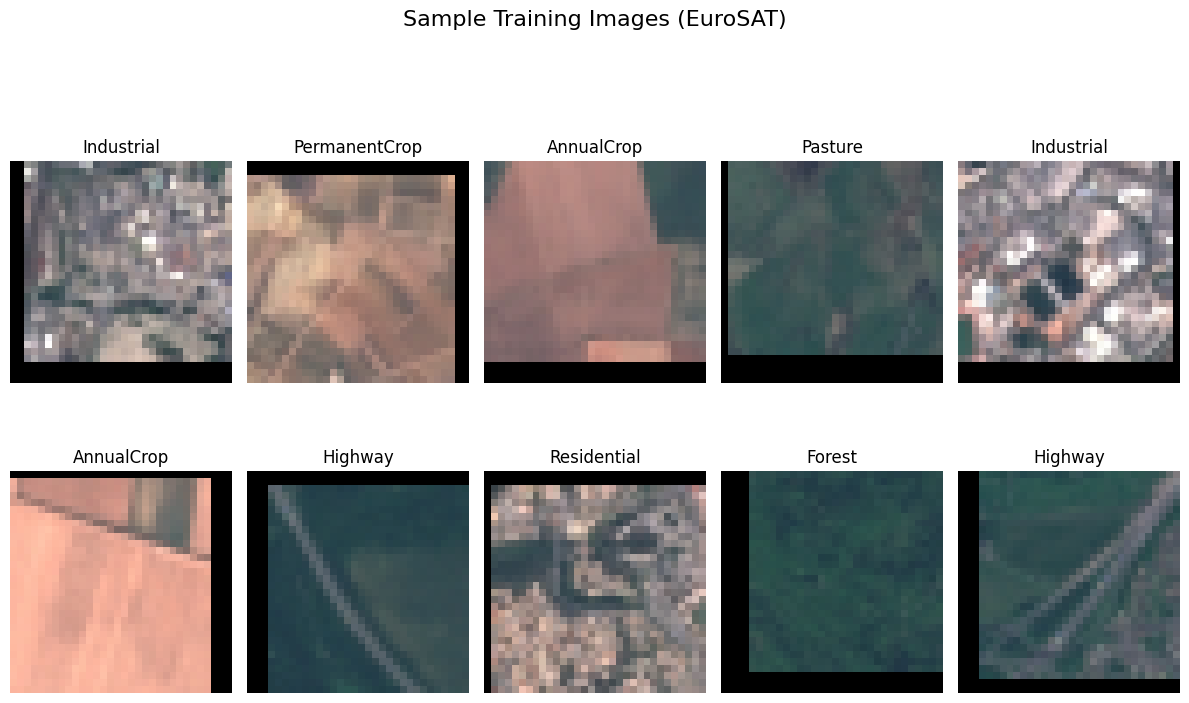

In [ ]:
def imshow(tensor_img, title=None):

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor_img = tensor_img * std + mean
    npimg = tensor_img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')


try:
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    plt.figure(figsize=(12, 8))
    for i in range(min(10, len(images))):
        plt.subplot(2, 5, i+1)
        imshow(images[i], title=class_names[labels[i].item()])
    plt.suptitle("Sample Training Images (EuroSAT)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
except StopIteration:
    print("Trainloader is empty or could not fetch a batch.")
except Exception as e:
    print(f"An error occurred during visualization: {e}")
    print("Make sure your trainloader is correctly populated.")

### 4: ResNet Introduction - The Degradation Problem

Before ResNet (Residual Networks), simply stacking more layers in a Deep Neural Network (DNN) often led to a peculiar issue known as the **degradation problem**. While deeper networks have more parameters and theoretically higher expressive power, practitioners found that very deep "plain" networks (like VGG-style networks, which are sequential stacks of layers) would see their training accuracy saturate and then quickly degrade. This wasn't merely overfitting (where training error is low but test error is high); the training error itself would increase. This indicated that deeper models were harder to optimize, even struggling to learn an identity mapping if that were the optimal solution for some layers. The ResNet architecture was primarily designed to address this degradation problem and enable the training of significantly deeper networks.

### 5: ResNet Core Idea - Residual Learning

The key innovation in ResNet is **residual learning**. Instead of expecting a stack of layers to directly learn a desired underlying mapping `H(x)` (where `x` is the input to the block), ResNet reformulates this. The layers are made to learn a *residual function* `F(x) = H(x) - x`. The original desired mapping is then `H(x) = F(x) + x`.

This is implemented using **shortcut connections** (or skip connections), which perform an identity mapping `x` that bypasses one or more layers. The output of the stacked layers `F(x)` is then added element-wise to `x`.

**Why this helps:**
1.  **Easier Optimization:** If the identity mapping (`x`) is optimal for a block, it's easier for the non-linear layers to learn to push the residual `F(x)` to zero, rather than learning an identity mapping from scratch.
2.  **Improved Gradient Flow:** Shortcuts provide direct paths for gradients to propagate during backpropagation, mitigating the vanishing gradient problem in very deep networks.

In [ ]:
# --- ResNet Model Definition ---
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()

        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block_type, num_blocks_list, num_classes=10, use_dropout=False, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.use_dropout = use_dropout


        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)


        self.layer1 = self._make_layer(block_type, 16, num_blocks_list[0], stride=1)
        self.layer2 = self._make_layer(block_type, 32, num_blocks_list[1], stride=2)
        self.layer3 = self._make_layer(block_type, 64, num_blocks_list[2], stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        if self.use_dropout:
            self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(64 * block_type.expansion, num_classes)

    def _make_layer(self, block_type, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block_type(self.in_planes, planes, s))
            self.in_planes = planes * block_type.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1) # Flatten
        if self.use_dropout:
            out = self.dropout(out)
        out = self.linear(out)
        return out


def ResNet32(use_dropout=False, dropout_rate=0.5, num_classes=10):

    return ResNet(BasicBlock, [5, 5, 5], num_classes=num_classes, use_dropout=use_dropout, dropout_rate=dropout_rate)

print("ResNet model definition complete.")

ResNet model definition complete.


###  7: Training Configuration and Initialization

This cell defines hyperparameters for training, initializes the ResNet-32 model, sets up the loss function (CrossEntropyLoss), optimizer (SGD), and a learning rate scheduler (`ReduceLROnPlateau`). Warmup parameters are also defined here.

In [ ]:
# --- Hyperparameters & Training Setup ---
MAX_EPOCHS = 35
PATIENCE_EARLY_STOPPING = 10
PATIENCE_LR_SCHEDULER = 5
FACTOR_LR_SCHEDULER = 0.2

TARGET_INITIAL_LR = 0.01
WARMUP_EPOCHS = 3
WARMUP_START_LR = 1e-5

MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
USE_DROPOUT = True
DROPOUT_RATE = 0.25
MODEL_SAVE_PATH = 'best_resnet32_eurosat_final.pth'

print('==> Building and initializing model for training...')
net = ResNet32(use_dropout=USE_DROPOUT, dropout_rate=DROPOUT_RATE, num_classes=NUM_CLASSES)
net = net.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=WARMUP_START_LR,
                      momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=FACTOR_LR_SCHEDULER,
                                                       patience=PATIENCE_LR_SCHEDULER,
                                                       verbose=True, min_lr=1e-6)
print("Training setup complete.")

==> Building and initializing model for training...
Training setup complete.


###  8: Training and Evaluation Functions

Defines two core functions:
1.  `train(epoch)`: Handles one epoch of training. It iterates through the `trainloader`, performs forward and backward passes, updates model weights, and logs training loss and accuracy.
2.  `test(dataloader_to_test, model_to_test)`: Evaluates the given model on the provided dataloader (e.g., `valloader` or `testloader`). It calculates and returns the average loss and accuracy.

In [ ]:
def train_one_epoch(epoch_num, current_model, current_optimizer, current_criterion, current_trainloader):
    current_lr = current_optimizer.param_groups[0]['lr']
    print(f'\nEpoch: {epoch_num+1}/{MAX_EPOCHS} -- LR: {current_lr:.7f}')
    current_model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(current_trainloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        current_optimizer.zero_grad()
        outputs = current_model(inputs)
        loss = current_criterion(outputs, targets)
        loss.backward()
        current_optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx + 1) % (len(current_trainloader) // 4 or 1) == 0 or batch_idx == len(current_trainloader)-1: # Print ~4 times per epoch
             print(f'  Train Batch {batch_idx+1}/{len(current_trainloader)} | Loss: {train_loss/(batch_idx+1):.4f} | Acc: {100.*correct/total:.2f}% ({correct}/{total})')

    avg_loss = train_loss / len(current_trainloader)
    avg_acc = 100. * correct / total
    return avg_loss, avg_acc

def evaluate_model(dataloader_to_eval, model_to_eval, current_criterion):
    model_to_eval.eval()
    eval_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader_to_eval):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model_to_eval(inputs)
            loss = current_criterion(outputs, targets)
            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    avg_loss = eval_loss / len(dataloader_to_eval)
    avg_acc = 100. * correct / total
    return avg_loss, avg_acc

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


###  9: Main Training Loop

This cell executes the main training loop.
- It iterates for a `MAX_EPOCHS`.
- **Learning Rate Warmup:** For the first `WARMUP_EPOCHS`, the learning rate is linearly increased from `WARMUP_START_LR` to `TARGET_INITIAL_LR`.
- After warmup, the `ReduceLROnPlateau` scheduler takes over LR adjustments based on validation loss.
- **Early Stopping:** Training stops if validation loss doesn't improve for `PATIENCE_EARLY_STOPPING` epochs.
- **Best Model Saving:** The model weights yielding the best validation loss are saved.
- Training and validation losses/accuracies are recorded for plotting.

In [ ]:
train_losses_history, val_losses_history = [], []
train_accs_history, val_accs_history = [], []
lr_history = []

best_val_loss = float('inf')
epochs_no_improve_val_loss = 0
best_model_state = None

print("Starting training...")
overall_start_time = time.time()

for epoch in range(MAX_EPOCHS):
    epoch_start_time = time.time()


    if epoch < WARMUP_EPOCHS:
        lr_step = (TARGET_INITIAL_LR - WARMUP_START_LR) / WARMUP_EPOCHS
        current_lr = WARMUP_START_LR + lr_step * (epoch + 1)
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
    elif epoch == WARMUP_EPOCHS:
        print(f"Warmup complete. Setting LR to {TARGET_INITIAL_LR}")
        for param_group in optimizer.param_groups:
            param_group['lr'] = TARGET_INITIAL_LR

    lr_history.append(optimizer.param_groups[0]['lr'])


    epoch_train_loss, epoch_train_acc = train_one_epoch(epoch, net, optimizer, criterion, trainloader)
    train_losses_history.append(epoch_train_loss)
    train_accs_history.append(epoch_train_acc)


    epoch_val_loss, epoch_val_acc = evaluate_model(valloader, net, criterion)
    val_losses_history.append(epoch_val_loss)
    val_accs_history.append(epoch_val_acc)

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} Summary: Duration: {epoch_duration:.2f}s | Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}% | Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")


    if epoch >= WARMUP_EPOCHS:
        scheduler.step(epoch_val_loss)


    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve_val_loss = 0
        best_model_state = copy.deepcopy(net.state_dict())
        torch.save(best_model_state, MODEL_SAVE_PATH)
        print(f"Validation loss improved to {best_val_loss:.4f}. Best model saved to {MODEL_SAVE_PATH}")
    else:
        epochs_no_improve_val_loss += 1
        print(f"Validation loss did not improve for {epochs_no_improve_val_loss} epoch(s). Current best: {best_val_loss:.4f}")


    if epochs_no_improve_val_loss >= PATIENCE_EARLY_STOPPING:
        print(f"Early stopping triggered after {epoch+1} epochs as validation loss did not improve.")
        if best_model_state:
            net.load_state_dict(best_model_state)
            print("Loaded best model weights due to early stopping.")
        break

overall_training_time = time.time() - overall_start_time
print(f"\nTotal training time: {overall_training_time/60:.2f} minutes ({overall_training_time:.2f} seconds)")

Starting training...

Epoch: 1/35 -- LR: 0.0033400
  Train Batch 36/147 | Loss: 1.9289 | Acc: 30.88% (1423/4608)
  Train Batch 72/147 | Loss: 1.6353 | Acc: 41.78% (3850/9216)
  Train Batch 108/147 | Loss: 1.4737 | Acc: 47.32% (6541/13824)
  Train Batch 144/147 | Loss: 1.3663 | Acc: 51.30% (9455/18432)
  Train Batch 147/147 | Loss: 1.3581 | Acc: 51.62% (9713/18816)
Epoch 1 Summary: Duration: 8.66s | Train Loss: 1.3581, Acc: 51.62% | Val Loss: 1.0733, Acc: 59.98%
Validation loss improved to 1.0733. Best model saved to best_resnet32_eurosat_final.pth

Epoch: 2/35 -- LR: 0.0066700
  Train Batch 36/147 | Loss: 1.0404 | Acc: 63.93% (2946/4608)
  Train Batch 72/147 | Loss: 0.9639 | Acc: 66.42% (6121/9216)
  Train Batch 108/147 | Loss: 0.9214 | Acc: 67.63% (9349/13824)
  Train Batch 144/147 | Loss: 0.8964 | Acc: 68.26% (12581/18432)
  Train Batch 147/147 | Loss: 0.8990 | Acc: 68.29% (12849/18816)
Epoch 2 Summary: Duration: 8.79s | Train Loss: 0.8990, Acc: 68.29% | Val Loss: 1.4594, Acc: 55.41%

### 10: Plotting Training Progress and Final Evaluation

This cell visualizes the training progress:
1.  Plots training vs. validation loss over epochs.
2.  Plots training vs. validation accuracy over epochs.
3.  Plots learning rate schedule over epochs.

Finally, it loads the best model (saved based on validation loss) and evaluates its performance on the unseen test set.

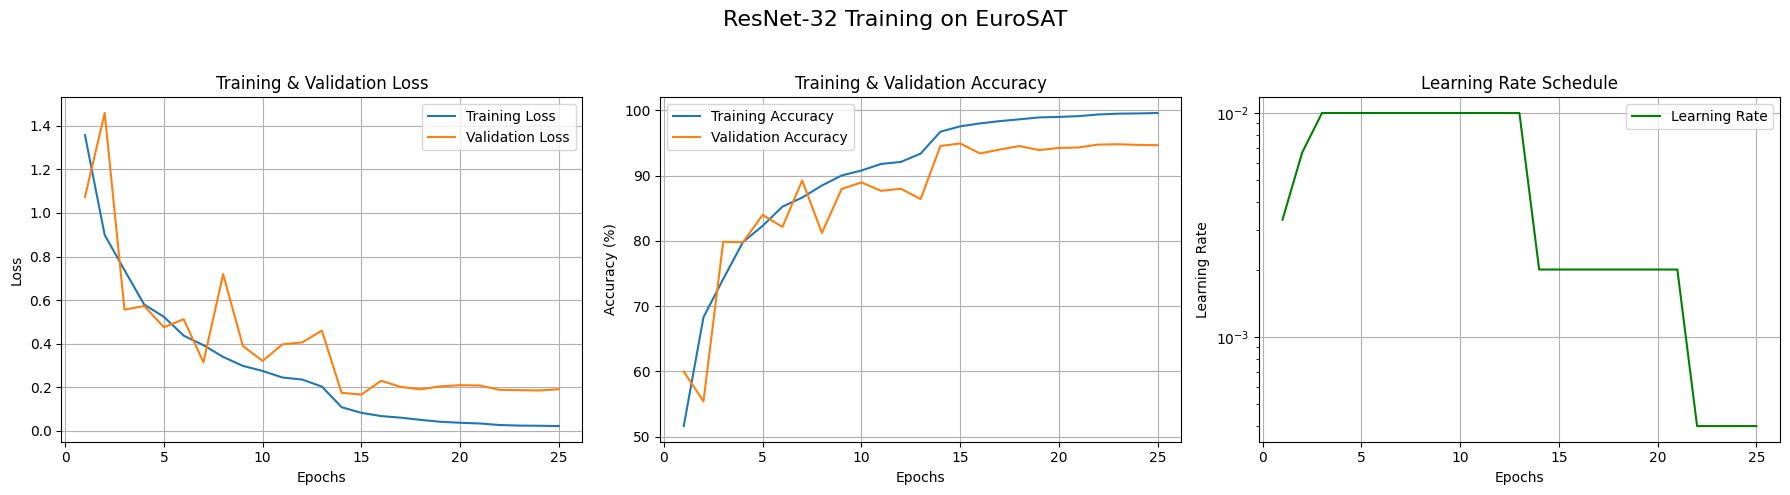

==> Training finished. Plots saved to resnet32_eurosat_training_summary.png
Best validation loss achieved during training: 0.1661
Best validation accuracy achieved: 94.91% at epoch 15

==> Evaluating best model (based on val_loss) on test set...
Performance of Best Model on Test Set: Loss: 0.2027, Accuracy: 93.93%
Script complete.


In [ ]:
actual_epochs_trained = len(train_losses_history)
epochs_plot_range = range(1, actual_epochs_trained + 1)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_plot_range, train_losses_history, label='Training Loss')
plt.plot(epochs_plot_range, val_losses_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_plot_range, train_accs_history, label='Training Accuracy')
plt.plot(epochs_plot_range, val_accs_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs_plot_range, lr_history, label='Learning Rate', color='green')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.yscale('log')

plt.suptitle("ResNet-32 Training on EuroSAT", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('resnet32_eurosat_training_summary.png')
plt.show()

print(f"==> Training finished. Plots saved to resnet32_eurosat_training_summary.png")
print(f"Best validation loss achieved during training: {best_val_loss:.4f}")
if val_accs_history:
    best_val_acc_epoch = np.argmax(val_accs_history)
    print(f"Best validation accuracy achieved: {val_accs_history[best_val_acc_epoch]:.2f}% at epoch {best_val_acc_epoch+1}")



if os.path.exists(MODEL_SAVE_PATH):
    print("\n==> Evaluating best model (based on val_loss) on test set...")
    net.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    test_final_loss, test_final_acc = evaluate_model(testloader, net, criterion)
    print(f"Performance of Best Model on Test Set: Loss: {test_final_loss:.4f}, Accuracy: {test_final_acc:.2f}%")
else:
    print("\n==> No 'best' model was saved. Evaluating current model state on test set (if training completed).")
    if actual_epochs_trained > 0:
        test_final_loss, test_final_acc = evaluate_model(testloader, net, criterion)
        print(f"Performance of Last Model State on Test Set: Loss: {test_final_loss:.4f}, Accuracy: {test_final_acc:.2f}%")
    else:
        print("No training was performed to evaluate the last model state.")

print("Script complete.")

###  11: Visualizing Model Predictions

This cell takes a batch of data from the test set, runs it through the trained (best) model, and displays the images along with their true and predicted labels. Incorrect predictions are highlighted in red.


==> Visualizing predictions with the best model...


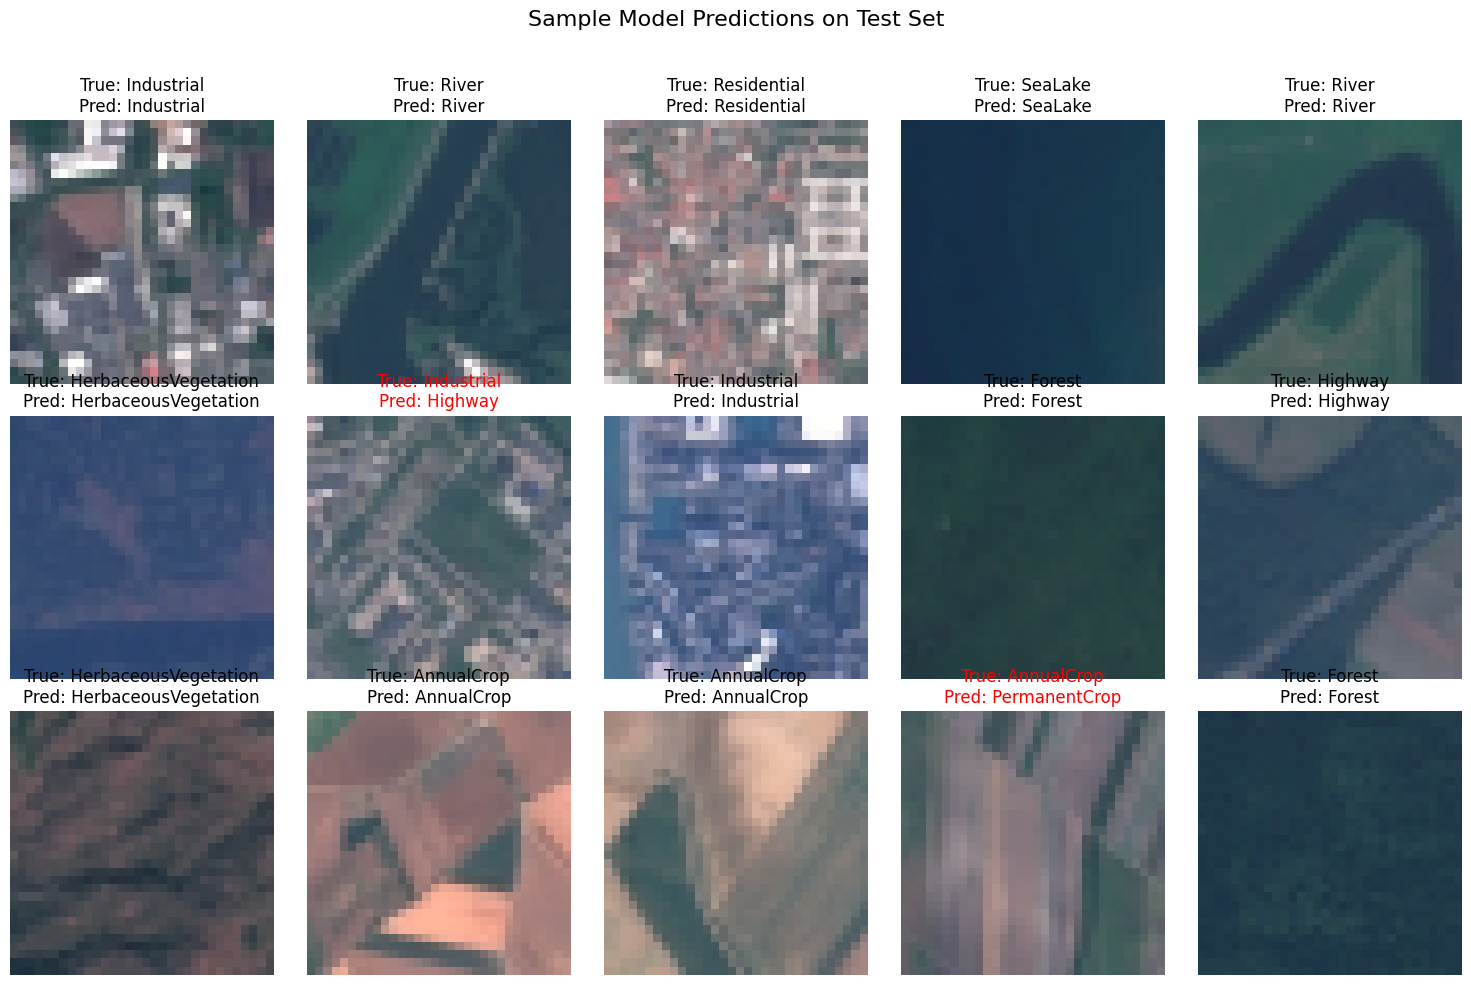

In [ ]:
def visualize_predictions(model, dataloader, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0

    plt.figure(figsize=(15, 10))
    with torch.no_grad():
        try:
            data_iter = iter(dataloader)
            images, labels = next(data_iter)
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_so_far >= num_images:
                    break
                images_so_far += 1
                ax = plt.subplot( (num_images + 4) // 5 , 5, images_so_far)


                img_to_show = images.cpu().data[i]

                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]

                title_str = f"True: {true_label}\nPred: {pred_label}"
                imshow(img_to_show, title=title_str)

                if preds[i] != labels[i]:
                    ax.title.set_color('red')

        except StopIteration:
            print("Dataloader exhausted or empty.")
        except Exception as e:
            print(f"An error occurred during prediction visualization: {e}")

    plt.suptitle("Sample Model Predictions on Test Set", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    model.train(mode=was_training)

if os.path.exists(MODEL_SAVE_PATH):
    print("\n==> Visualizing predictions with the best model...")
    net.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    visualize_predictions(net, testloader, num_images=15)
else:
    print("No best model saved to visualize predictions.")